In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15598, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 15598 (delta 98), reused 119 (delta 57), pack-reused 15393
Receiving objects: 100% (15598/15598), 14.64 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (10622/10622), done.


In [2]:
cd yolov5

/kaggle/working/yolov5


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
  Attempting uninstall: gitpython
    Found existing installation: GitPython 3.1.27
    Uninstalling GitPython-3.1.27:
      Successfully uninstalled GitPython-3.1.27
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
google-api-core 1.33.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 3.19.4 which is inc

In [4]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

In [5]:
input_path = '/kaggle/input/road-sign-detection'
output_path = '/kaggle/working/yolov5'

In [6]:
annotations_path = os.path.join(input_path, 'annotations')
annotations = os.listdir(annotations_path)

In [7]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text
        
        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

100%|██████████| 877/877 [00:03<00:00, 222.96it/s]


In [8]:
labels_df = pd.DataFrame({
                        'img_name': img_name_list, 
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label
0,road732.png,300,400,99,97,159,157,speedlimit
1,road732.png,300,400,104,189,165,250,speedlimit
2,road518.png,300,400,157,165,184,191,speedlimit
3,road717.png,300,400,90,219,109,240,speedlimit
4,road717.png,300,400,116,220,136,240,speedlimit


In [9]:
!pip install pybboxes

In [10]:
import numpy as np
import pandas as pd
import os
import pybboxes as pbx
from collections import defaultdict
from tqdm import tqdm
import shutil

In [11]:
classes = labels_df['label'].unique().tolist()
classes

['speedlimit', 'trafficlight', 'crosswalk', 'stop']

In [12]:
## Add class number associated to classes
labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,class
0,road732.png,300,400,99,97,159,157,speedlimit,0
1,road732.png,300,400,104,189,165,250,speedlimit,0
2,road518.png,300,400,157,165,184,191,speedlimit,0
3,road717.png,300,400,90,219,109,240,speedlimit,0
4,road717.png,300,400,116,220,136,240,speedlimit,0


In [13]:
## Generate dictionary where key is image_name and value is list of all bboxes inforamtion
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))
    
    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)

100%|██████████| 1244/1244 [00:00<00:00, 5729.66it/s]


In [14]:
# make labels dir in data folder of yolov5
labels_dir = f'{output_path}/data/labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [15]:
## Generate .txt file for each image
for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [16]:
import os
import shutil
from random import shuffle

In [17]:
images_path = input_path + '/images'
labels_path = labels_dir   ## directory having labels in .txt format

In [18]:
# create train , val folders in data directory of yolov5
train_dir = output_path + '/data/train'
val_dir = output_path + '/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
    
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
    
os.mkdir(train_dir)
os.mkdir(val_dir)

# train, val each containing images and labels folders
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')

In [19]:
# Shuffle image file names before splitting into train and val data
files = os.listdir(images_path)
shuffle(files)

In [20]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]

def copy_files(images_path, labels_path, destination_path, files):
    
    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [21]:
images_path, labels_path, train_dir

('/kaggle/input/road-sign-detection/images',
 '/kaggle/working/yolov5/data/labels',
 '/kaggle/working/yolov5/data/train')

In [22]:
# Split and copy files in train and val folder
train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

root = 'data/traffic_sign_data'

copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [23]:
assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

In [24]:
with open(f'{output_path}/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

In [25]:
epochs = 20
!python train.py --img 640 --batch 16 --epochs {epochs} --data sign_data.yaml --weights yolov5s.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=sign_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralyt

In [26]:
# results stored in runs/train 
# get the last stored result
exp = sorted(os.listdir(output_path + '/runs/train'))[-1]
exp_path = output_path + '/runs/train/' + exp

In [27]:
os.listdir(exp_path)

['val_batch1_labels.jpg',
 'labels.jpg',
 'val_batch2_labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_pred.jpg',
 'PR_curve.png',
 'P_curve.png',
 'opt.yaml',
 'weights',
 'results.csv',
 'results.png',
 'train_batch2.jpg',
 'confusion_matrix.png',
 'val_batch0_pred.jpg',
 'train_batch0.jpg',
 'labels_correlogram.jpg',
 'hyp.yaml',
 'R_curve.png',
 'F1_curve.png',
 'val_batch0_labels.jpg',
 'events.out.tfevents.1682551433.70117f65c20d.116.0',
 'train_batch1.jpg']

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

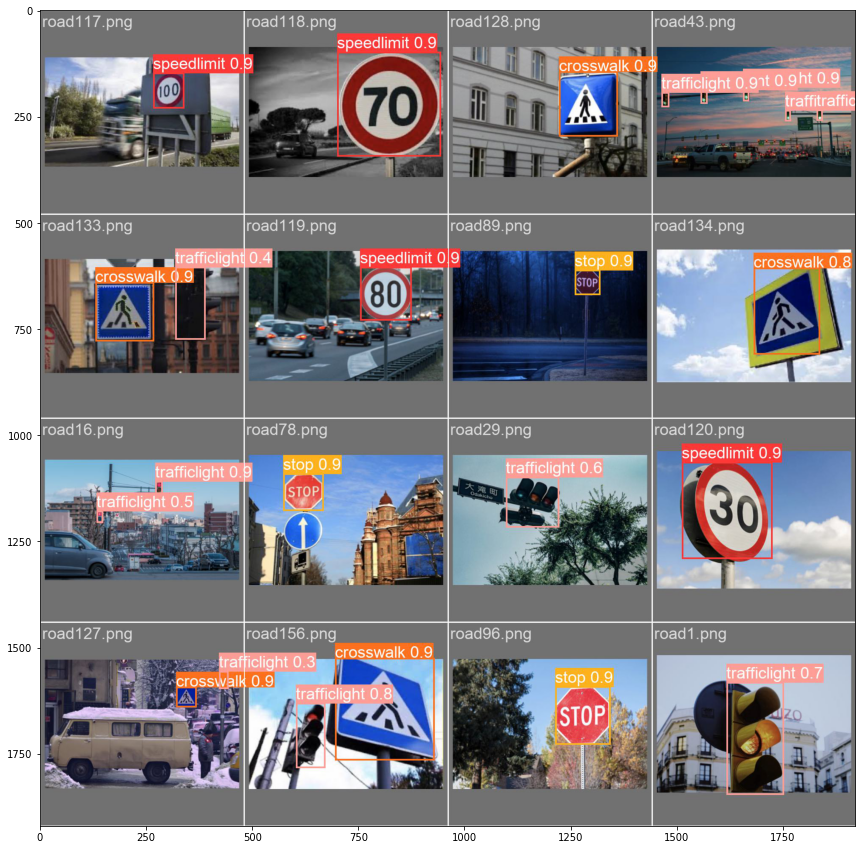

In [29]:
img_path = exp_path + '/val_batch0_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)